In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab_Notebooks/marketing_campaign.csv",sep='\t')
display(df)
print(df.describe())
print(df.info)
print(df.isnull().sum())
for col in df.columns:
    print(f"\nValue counts for column '{col}':")
    print(df[col].value_counts())


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000     0.000000     0.000000  

**1. Tiền xử lý để làm RFM.**

In [ ]:
# tạo 2 cột tính tổng tiền, tổng số lần mua hàng để chạy RFM
df["Monetary"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df["Frequency"] = df["NumDealsPurchases"] + df["NumWebPurchases"] + df["NumCatalogPurchases"] + df["NumStorePurchases"]

In [ ]:
# Tiền xử lý
#1. Xóa trùng lập
df.drop_duplicates()
#2. Xử lý null cột income, xóa null vì tỷ lệ null thấp
df['Income'].dropna()
#3. Cột tình trạng hôn nhân có dữ liệu cùng nghĩa nên gom lại,cột giáo dục có dữ liệu cùng nghĩa nên gom lại
df["Marital_Status"] = df["Marital_Status"].replace(["Married","Together"],"Partner")
df["Marital_Status"] = df["Marital_Status"].replace(["Widow","Alone","Absurd","YOLO"],"Single")
df["Education"] = df["Education"].replace(["Master","2n Cycle","PhD"],"PostGraduate")
df["Education"] = df["Education"].replace(["Graduation"],"Graduate")
df["Education"] = df["Education"].replace(["Basic"],"UnderGraduate")

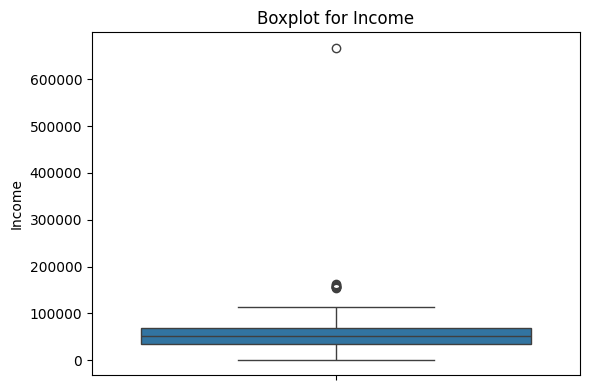

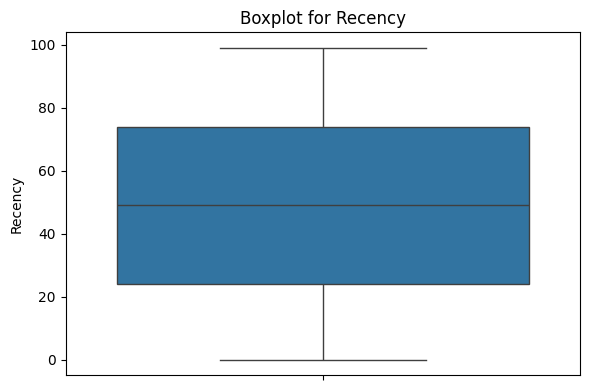

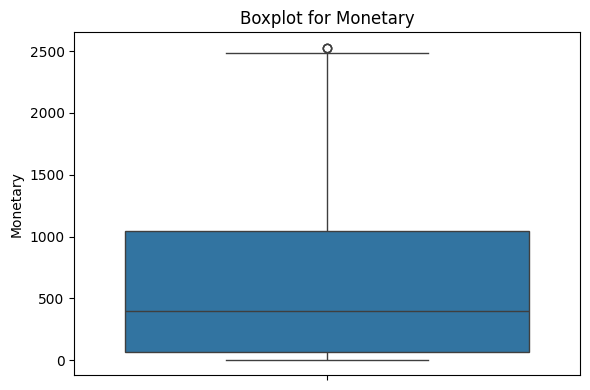

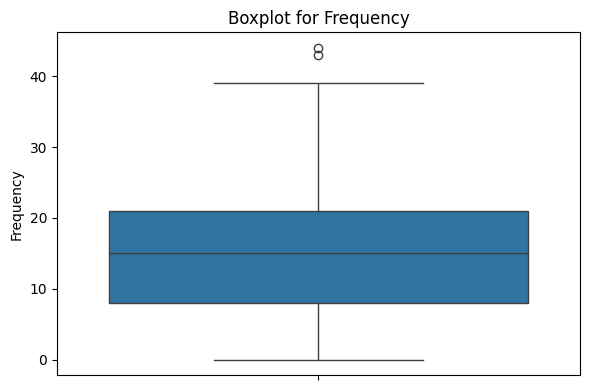

In [ ]:

cols = ["Income", "Recency", "Monetary", "Frequency"]

for col in cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()
    plt.show()


Income: 8 outliers removed.
Recency: 0 outliers removed.
Monetary: 3 outliers removed.
Frequency: 1 outliers removed.


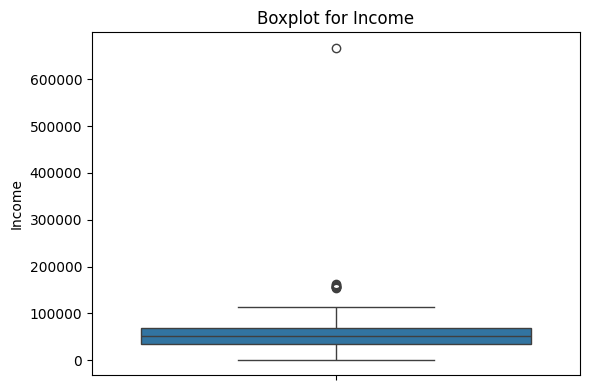

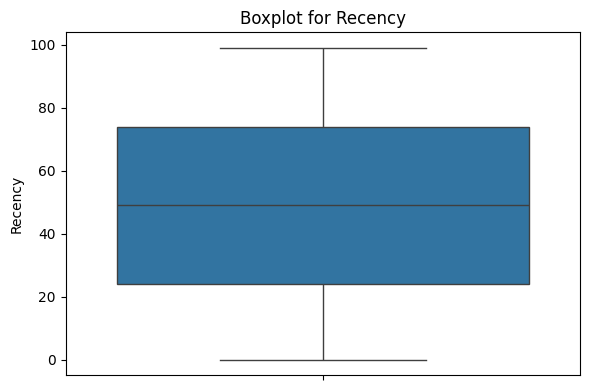

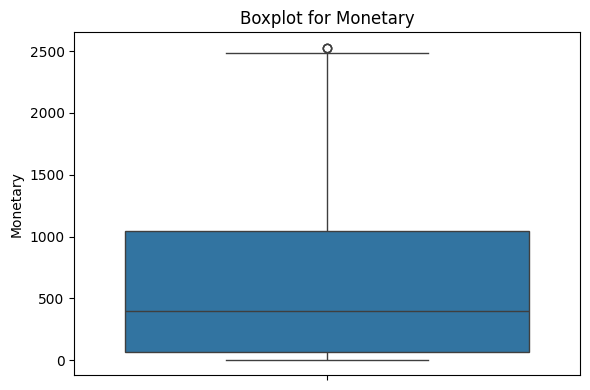

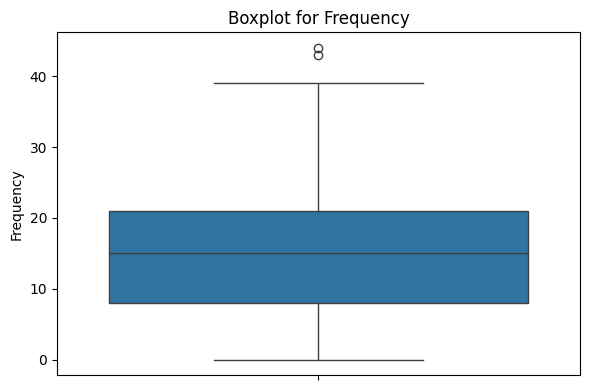

In [ ]:
def remove_outliers_iqr(df, cols):
    """
    Xóa outliers theo phương pháp IQR và in số lượng outlier bị loại bỏ.
    """
    df_cleaned = df.copy()

    for col in cols:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Đếm outliers
        num_outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)].shape[0]
        print(f"{col}: {num_outliers} outliers removed.")

        # Xoá outliers
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned
cols = ["Income", "Recency", "Monetary", "Frequency"]
df_cleaned = remove_outliers_iqr(df, cols)
cols = ["Income", "Recency", "Monetary", "Frequency"]

for col in cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()
    plt.show()


In [ ]:
print(df.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Monetary', 'Frequency'],
      dtype='object')


In [ ]:
# 1. Đổi ngày tháng thành dạng datetime
#df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

# 3. Thêm cột tuổi
df['Age'] = 2025 - df['Year_Birth']


# 5. Kiểm tra các giá trị bất thường (ví dụ: năm sinh), bỏ mấy tủi già già
print(df[df['Year_Birth'] < 1900])

# 6. Value counts cho các cột text
print(df['Education'].value_counts())
print(df['Marital_Status'].value_counts())


        ID  Year_Birth     Education Marital_Status   Income  Kidhome  \
239  11004        1893  PostGraduate         Single  60182.0        0   
339   1150        1899  PostGraduate        Partner  83532.0        0   

     Teenhome Dt_Customer  Recency  MntWines  ...  AcceptedCmp5  AcceptedCmp1  \
239         1  17-05-2014       23         8  ...             0             0   
339         0  26-09-2013       36       755  ...             1             0   

     AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response  Monetary  \
239             0         0              3         11         0        22   
339             0         0              3         11         0      1853   

     Frequency  Age  
239          4  132  
339         15  126  

[2 rows x 32 columns]
Education
Graduate         1127
PostGraduate     1059
UnderGraduate      54
Name: count, dtype: int64
Marital_Status
Partner     1444
Single       564
Divorced     232
Name: count, dtype: int64


In [ ]:
#Vì các cột "Z_CostContact" và "Z_Revenue"
#luôn có cùng giá trị nên chúng không đóng góp thông tin có ý nghĩa cho mô hình => bỏ
droped = ["Z_CostContact", "Z_Revenue"]
df = df.drop(droped, axis = 1)

In [ ]:
display(df)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Monetary,Frequency,Age
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,0,1,1617,25,68
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,0,27,6,71
2,4141,1965,Graduate,Partner,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,0,776,21,60
3,6182,1984,Graduate,Partner,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,0,0,53,8,41
4,5324,1981,PostGraduate,Partner,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,0,0,422,19,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduate,Partner,61223.0,0,1,2013-06-13,46,709,...,0,0,0,0,0,0,0,1341,18,58
2236,4001,1946,PostGraduate,Partner,64014.0,2,1,2014-06-10,56,406,...,0,0,0,1,0,0,0,444,22,79
2237,7270,1981,Graduate,Divorced,56981.0,0,0,2014-01-25,91,908,...,0,1,0,0,0,0,0,1241,19,44
2238,8235,1956,PostGraduate,Partner,69245.0,0,1,2014-01-24,8,428,...,0,0,0,0,0,0,0,843,23,69


In [ ]:
print(df.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Monetary', 'Frequency', 'Age'],
      dtype='object')


In [ ]:
df.to_csv(r"/content/drive/MyDrive/Colab_Notebooks/data_clean.csv", index=False)

In [ ]:
rfm = df[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [ ]:
! pip install kneed

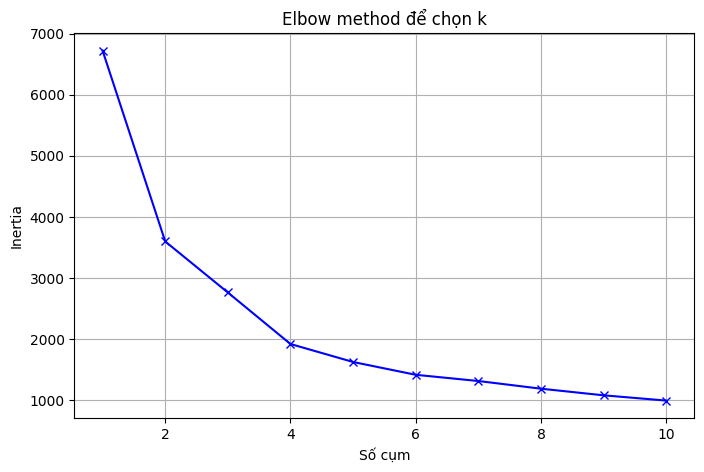

Số cụm tối ưu được chọn: 4


In [ ]:
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k_ in K:
    mbk = MiniBatchKMeans(n_clusters=k_, random_state=42, batch_size=64)
    mbk.fit(rfm_scaled)
    inertia.append(mbk.inertia_)

# Vẽ biểu đồ Elbow
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Số cụm')
plt.ylabel('Inertia')
plt.title('Elbow method để chọn k')
plt.grid(True)
plt.show()

# Tìm điểm gãy (elbow) tự động
kl = KneeLocator(K, inertia, curve="convex", direction="decreasing")
k = kl.elbow
print(f"Số cụm tối ưu được chọn: {k}")


In [ ]:
optimal_k = k  # Chọn từ kết quả Elbow ở bước trên
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=64)
df['Cluster'] = kmeans.fit_predict(rfm_scaled)


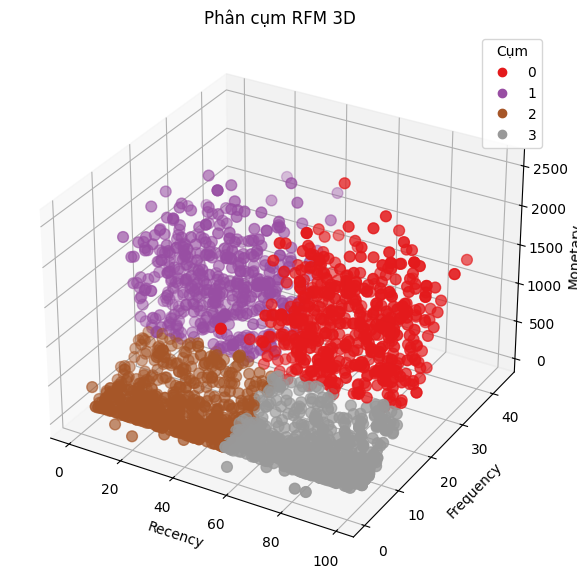

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Giả sử df['Cluster'] là cột chứa nhãn cụm (cluster labels)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Tạo scatter plot và lưu đối tượng scatter
scatter = ax.scatter(df['Recency'], df['Frequency'], df['Monetary'],
                      c=df['Cluster'], cmap='Set1', s=60)

ax.set_title('Phân cụm RFM 3D')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Thêm legend để chỉ ra các cụm
plt.legend(*scatter.legend_elements(), title="Cụm")
plt.show()


Silhouette Score trung bình: 0.3775


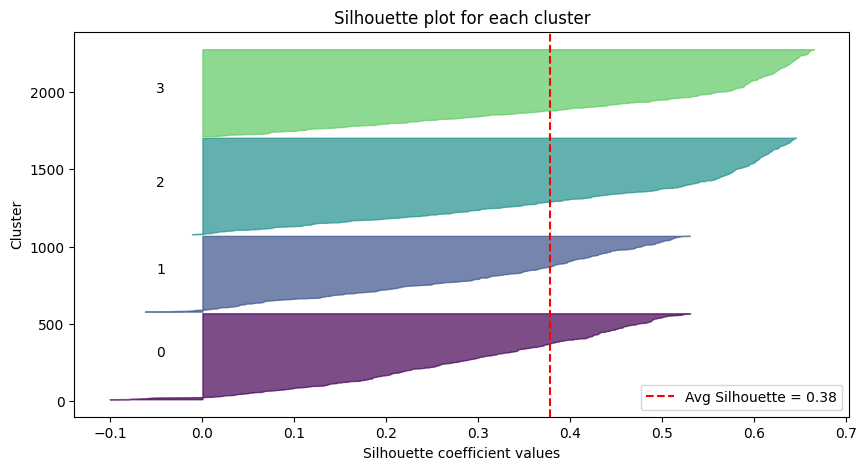

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Tính tất cả các giá trị silhouette cho từng điểm
sil_vals = silhouette_samples(rfm_scaled, df['Cluster'])

# ✅ Tính chỉ số silhouette trung bình cho toàn bộ tập dữ liệu
avg_score = silhouette_score(rfm_scaled, df['Cluster'])

# ✅ In ra chỉ số silhouette trung bình
print(f"Silhouette Score trung bình: {avg_score:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
y_lower = 10
for i in range(optimal_k):
    ith_sil_vals = sil_vals[df['Cluster'] == i]
    ith_sil_vals.sort()
    size_cluster_i = ith_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / optimal_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # space between clusters

plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster")
plt.title("Silhouette plot for each cluster")
plt.axvline(x=avg_score, color="red", linestyle="--", label=f"Avg Silhouette = {avg_score:.2f}")
plt.legend()
plt.show()


In [ ]:
display(df.head())

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Monetary,Frequency,Age,Cluster
0,5524,1957,Graduate,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,1,1617,25,68,0
1,2174,1954,Graduate,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,27,6,71,2
2,4141,1965,Graduate,Partner,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,776,21,60,1
3,6182,1984,Graduate,Partner,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,0,53,8,41,2
4,5324,1981,PostGraduate,Partner,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,0,422,19,44,0


In [ ]:
from google.colab import files

# Lưu file
# Lưu toàn bộ dataset đã gán Cluster
df.to_csv("rfm_with_clusters.csv", index=False)
files.download("rfm_with_clusters.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cluster_profile = df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()
print(cluster_profile)


   Cluster    Recency  Frequency     Monetary
0        0  73.057348  21.327957  1130.374552
1        1  23.191057  22.119919  1153.380081
2        2  24.722045   8.924920   138.341853
3        3  75.093972   8.723404   127.968085


- Cụm 1 là tần suất mua lớn nhất, chi số tiền nhiều nhất và thời gian mua gần nhất
- Cụm 0 có tần suất mua lớn nhất, chi số tiền nhiều nhất nhưng đã lâu không mua lại
- Cụm 2 có tần suất mua ít, doanh thu chỉ bằng 1/10 cụm 0, cụm 1 nhưng thời gian mua gần
- Cụm 3 có lần mua ít, doanh thu ít cũng đã lâu không mua lại

In [ ]:
display (df)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Monetary,Frequency,Age,Cluster
0,5524,1957,Graduate,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,1,1617,25,68,0
1,2174,1954,Graduate,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,0,27,6,71,2
2,4141,1965,Graduate,Partner,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,0,776,21,60,1
3,6182,1984,Graduate,Partner,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,0,53,8,41,2
4,5324,1981,PostGraduate,Partner,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,0,422,19,44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduate,Partner,61223.0,0,1,13-06-2013,46,709,...,0,0,0,0,0,0,1341,18,58,1
2236,4001,1946,PostGraduate,Partner,64014.0,2,1,10-06-2014,56,406,...,0,0,1,0,0,0,444,22,79,0
2237,7270,1981,Graduate,Divorced,56981.0,0,0,25-01-2014,91,908,...,1,0,0,0,0,0,1241,19,44,0
2238,8235,1956,PostGraduate,Partner,69245.0,0,1,24-01-2014,8,428,...,0,0,0,0,0,0,843,23,69,1


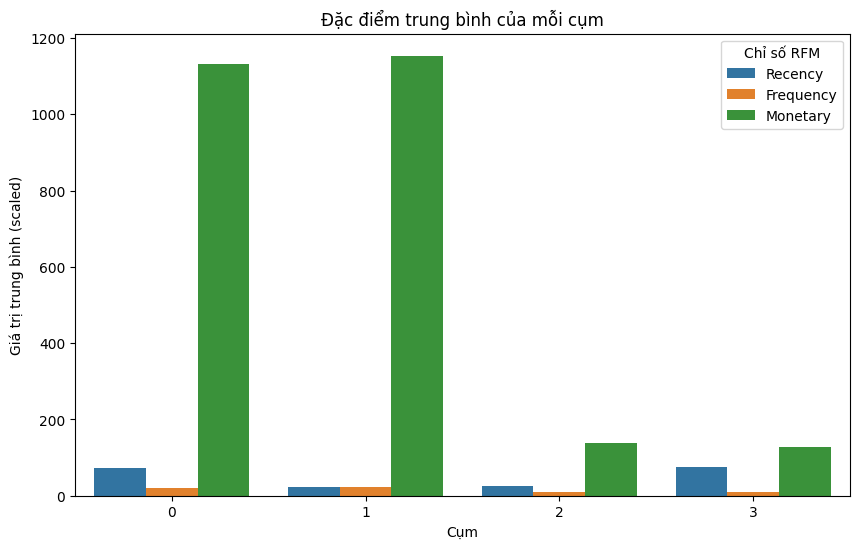

In [ ]:
# chart 1
cluster_melt = cluster_profile.melt(id_vars='Cluster', var_name='RFM_Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_melt, x='Cluster', y='Value', hue='RFM_Metric')
plt.title('Đặc điểm trung bình của mỗi cụm')
plt.ylabel('Giá trị trung bình (scaled)')
plt.xlabel('Cụm')
plt.legend(title='Chỉ số RFM')
plt.show()


In [ ]:
# Group by theo cụm và tính giá trị trung bình cho tất cả cột số
cluster_summary = df.groupby('Cluster').mean(numeric_only=True).round(2)
cluster_summary.T  # Transpose để dễ xem


Cluster,0,1,2,3
ID,5437.29,5625.85,5807.93,5476.50
Year_Birth,1966.33,1967.57,1970.78,1970.14
Income,68208.53,69455.56,38156.99,36950.72
Kidhome,0.14,0.15,0.69,0.73
Teenhome,0.53,0.49,0.50,0.51
Recency,73.06,23.19,24.72,75.09
MntWines,576.11,579.68,66.19,58.00
MntFruits,46.47,51.10,6.64,6.55
MntMeatProducts,316.29,329.01,29.95,29.88
MntFishProducts,68.41,69.93,10.20,9.03


In [ ]:
# chart2: bar chart
# nhóm độ tuổi và thu nhập
df['Age'] = 2025 - df['Year_Birth']
age_income = df.groupby('Cluster')[['Age', 'Income']].agg(['mean', 'median', 'min', 'max']).round(1)
print(age_income)


          Age                   Income                           
         mean median min  max     mean   median     min       max
Cluster                                                          
0        58.7   58.0  30   84  68208.5  67911.0  7144.0  157243.0
1        57.4   57.0  30  126  69455.6  69757.0  2447.0  160803.0
2        54.2   53.0  29  132  38157.0  36262.0  4023.0  666666.0
3        54.9   54.0  29  125  36950.7  36686.0  1730.0  156924.0


In [ ]:
# Tính giá trị trung bình của Age và Income theo từng Cluster
mean_values = df.groupby('Cluster')[['Age', 'Income']].mean()
mean_values.columns = ['Age_mean', 'Income_mean']  # Đổi tên cột cho rõ ràng


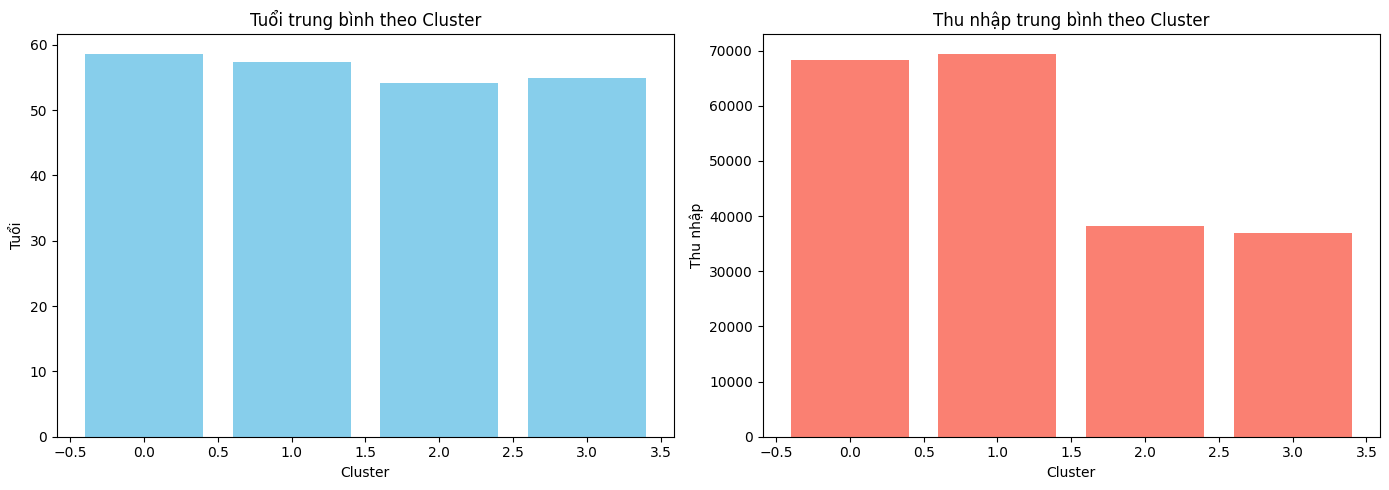

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ tuổi
axes[0].bar(mean_values.index, mean_values['Age_mean'], color='skyblue')
axes[0].set_title('Tuổi trung bình theo Cluster')
axes[0].set_ylabel('Tuổi')
axes[0].set_xlabel('Cluster')

# Biểu đồ thu nhập
axes[1].bar(mean_values.index, mean_values['Income_mean'], color='salmon')
axes[1].set_title('Thu nhập trung bình theo Cluster')
axes[1].set_ylabel('Thu nhập')
axes[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Giả sử df là DataFrame của bạn với dữ liệu đã được tải
df['Age'] = 2025 - df['Year_Birth']
age_income = df.groupby('Cluster')[['Age', 'Income']].agg(['mean', 'median', 'min', 'max']).round(1)

# Chuyển đổi kết quả thành định dạng JSON để sử dụng trong D3.js
age_income_json = age_income.to_json(orient='columns')

# Lưu vào một file JSON
with open('age_income_data.json', 'w') as f:
    f.write(age_income_json)


Nhóm 0,1 khách hàng trung niên thu nhập cao
Nhóm 2 khách hàng trung niên thu nhập thấp

In [ ]:
# chart 3: bar chart
# nhóm chi tiêu
mnt_cols = [col for col in df.columns if col.startswith('Mnt')]
df.groupby('Cluster')[mnt_cols].mean().round(1).T


Cluster,0,1,2,3
MntWines,576.1,579.7,66.2,58.0
MntFruits,46.5,51.1,6.6,6.5
MntMeatProducts,316.3,329.0,30.0,29.9
MntFishProducts,68.4,69.9,10.2,9.0
MntSweetProducts,50.3,51.1,5.9,6.5
MntGoldProds,72.8,72.5,19.4,18.0


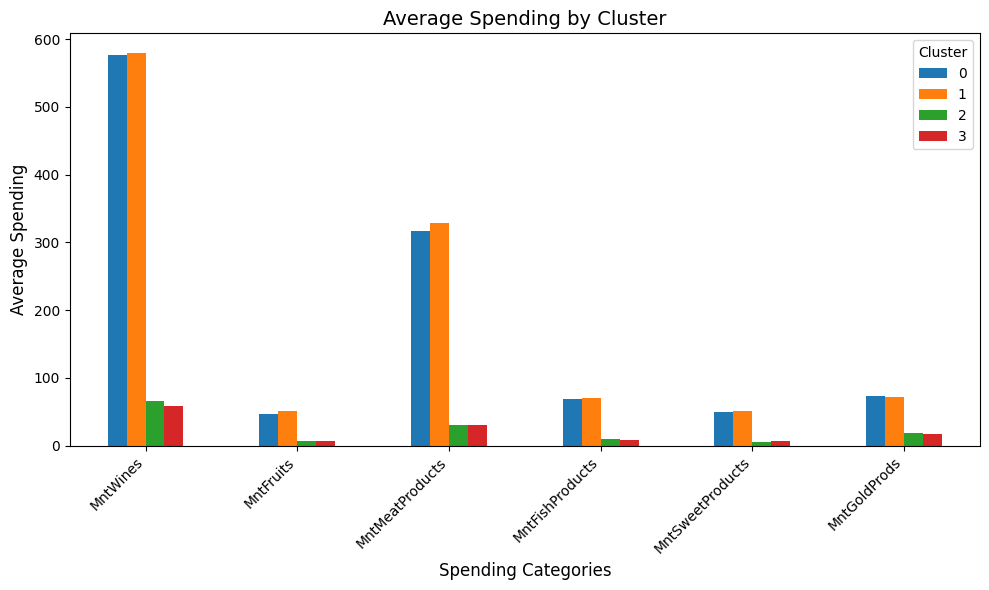

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is the DataFrame with your data

# Step 1: Select the 'Mnt' columns (spending columns)
mnt_cols = [col for col in df.columns if col.startswith('Mnt')]

# Step 2: Group by 'Cluster' and calculate the mean spending for each cluster
cluster_spending = df.groupby('Cluster')[mnt_cols].mean().round(1).T

# Step 3: Plotting the bar chart
cluster_spending.plot(kind='bar', figsize=(10, 6))

# Step 4: Add labels and title
plt.title('Average Spending by Cluster', fontsize=14)
plt.xlabel('Spending Categories', fontsize=12)
plt.ylabel('Average Spending', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


- Cụm 1 chi tiêu nhiều nhất cho hầu hết các loại sản phẩm trừ vàng thấp hơn cụm 0 một chút
- Cụm 0 chi tiêu nhiều ở hầu hết các loại sản phẩm thấp hơn cụm 1 một chút => sẵn sàng chi cho những sản phẩm đắt tiền nhất
- Cụm 2 chi tiêu ít, nhất là các sản phẩm ở trái cây, cá thịt, đồ ngọt => khách hàng có giá trị thấp, không mua nhiều hoặc mua thử.

In [ ]:
# nhóm nhân khẩu học
# Education
edu_dist = df.groupby('Cluster')['Education'].value_counts(normalize=True).unstack().round(2)

# chart 4: tròn
# Marital
marital_dist = df.groupby('Cluster')['Marital_Status'].value_counts(normalize=True).unstack().round(2)

print("Tỉ lệ Education theo cụm:")
print(edu_dist)

print("\nTỉ lệ Marital_Status theo cụm:")
print(marital_dist)


Tỉ lệ Education theo cụm:
Education  Graduate  PostGraduate  UnderGraduate
Cluster                                         
0              0.52          0.48           0.00
1              0.52          0.48            NaN
2              0.47          0.48           0.05
3              0.51          0.45           0.04

Tỉ lệ Marital_Status theo cụm:
Marital_Status  Divorced  Partner  Single
Cluster                                  
0                   0.11     0.64    0.25
1                   0.11     0.63    0.26
2                   0.09     0.67    0.24
3                   0.10     0.64    0.26


- Về trình độ học vấn thì tất cả các cụm điều có trình độ học vấn cao từ đại học trở lên chỉ có cụm 2 một bộ phận nhỏ dưới trình độ đại học
- Về tình trạng hôn nhân tất cả các cụm điều có tình trạng hôn nhân rất tương đồng
=> vấn đề nhân khẩu học không phải là yếu tố tác động đến các cụm

In [ ]:
# chart 5: tròn
# nhóm trẻ em
kid = df.groupby('Cluster')['Kidhome'].value_counts().unstack().fillna(0).astype(int)
teen = df.groupby('Cluster')['Teenhome'].value_counts().unstack().fillna(0).astype(int)
display(kid)
display(teen)



Kidhome,0,1,2
Cluster,,,
0,487,66,5
1,421,69,2
2,211,396,19
3,174,368,22


Teenhome,0,1,2
Cluster,,,
0,282,256,20
1,264,217,11
2,321,297,8
3,291,260,13


In [ ]:
# chart 6: stack bar
# nhóm hành vi mua sắm
purchase_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
df.groupby('Cluster')[purchase_cols].mean().round(1)


,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
Cluster,,,,,
0,2.5,5.8,4.8,8.2,4.2
1,2.6,6.1,4.9,8.5,4.3
2,2.1,2.5,0.7,3.6,6.3
3,2.1,2.4,0.7,3.5,6.3


- Cụm 1,0 hoạt động sôi nối trên mọi kênh => là các nhóm đa kênh, riêng mua qua web thì cụm 1 nhỉnh hơn hẳn, nhóm này không thường xuyên ghé thăm web bằng cụm 2 nhưng mua nhiều và thường xuyên mua không phụ thuộc nhiều vào khuyến mãi. Mua tại store vẫn chiếm ưu thế
Cụm 2 thường xuyên ghé thăm web nhất nhưng ít mua sắm => tò mò, thích xem hàng nhưng ít ra quyết định là nhóm tiềm năng cần có thể kích thích mua bằng các chương trình web-only vừa tăng lượng truy cập web của cụm 1,0 vừa kích thích khả năng mua của cụm 2.

In [ ]:
# nhóm phản hồi ý kiến và khiểu nại
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
df.groupby('Cluster')[cmp_cols].mean().round(2)
df.groupby('Cluster')['Complain'].mean().round(2)


,Complain
Cluster,
0,0.01
1,0.01
2,0.01
3,0.01


<Figure size 1000x600 with 0 Axes>

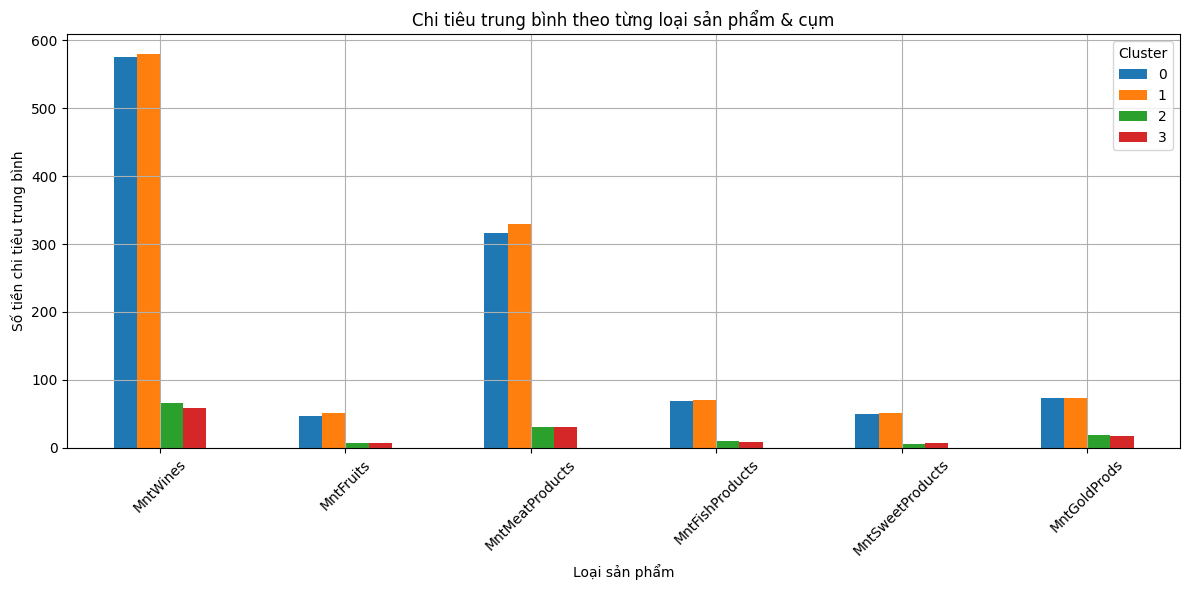

In [ ]:
# trực quan chi tiêu và sản phẩm
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
cluster_avg = df.groupby('Cluster')[mnt_cols].mean().T
cluster_avg.plot(kind='bar', figsize=(12,6))
plt.title('Chi tiêu trung bình theo từng loại sản phẩm & cụm')
plt.ylabel('Số tiền chi tiêu trung bình')
plt.xlabel('Loại sản phẩm')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


RFM


In [ ]:
import pandas as pd

# Giả sử bạn đã có 3 cột: 'Recency', 'Frequency', 'Monetary'
# Bước 1: Tính điểm R, F, M theo quantile
r_labels = [5, 4, 3, 2, 1]  # Recency càng thấp càng tốt
f_labels = m_labels = [1, 2, 3, 4, 5]  # Frequency và Monetary càng cao càng tốt

df['R_score'] = pd.qcut(df['Recency'], 5, labels=r_labels)
df['F_score'] = pd.qcut(df['Frequency'].rank(method='first'), 5, labels=f_labels)
df['M_score'] = pd.qcut(df['Monetary'].rank(method='first'), 5, labels=m_labels)

# Bước 2: Tính RFM tổng hợp
df['RFM_score'] = df['R_score'].astype(str) + df['F_score'].astype(str) + df['M_score'].astype(str)

# Bước 3: Gán nhãn phân khúc dựa trên quy tắc
def segment(r, f, m):
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal'
    elif r >= 3 and f >= 2:
        return 'Potential Loyalists'
    elif r >= 2 and f >= 2:
        return 'Needs Attention'
    elif r >= 1 and f >= 1:
        return 'At Risk'
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    else:
        return 'Promising'

df['Segment'] = df.apply(lambda row: segment(int(row['R_score']), int(row['F_score']), int(row['M_score'])), axis=1)


- Champions: 	Mua gần đây, mua thường xuyên, chi nhiều
- Loyal: Khách trung thành, giá trị cao
- Potential Loyalists: Gần với loyal – có tiềm năng
- Need Attention: có mua nhưng yếu dần
- At risk: Có dấu hiệu rời bỏ
- Hibernating: Lâu rồi không mua, không còn hoạt động
- Promissing: Mới, chi chưa nhiều, có thể nuôi dưỡng

In [ ]:
# Đếm số khách trong mỗi phân khúc
segment_counts = df['Segment'].value_counts()
print(segment_counts)

# Hoặc xem các đặc điểm từng nhóm
segment_profile = df.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
print(segment_profile)


Segment
At Risk                806
Loyal                  500
Needs Attention        362
Potential Loyalists    291
Champions              281
Name: count, dtype: int64
                     Recency  Frequency  Monetary
Segment                                          
At Risk                 66.5       10.5     352.6
Champions               19.4       23.7    1226.5
Loyal                   34.8       18.8     825.6
Needs Attention         69.5       17.1     781.4
Potential Loyalists     28.8        9.1     111.5


- At risk: có rất nhiều khách hàng lâu rồi chưa quay lại, mua ít, chi ít => mua thử nhưng không hài lòng chỉ mua một lần rồi biến mất
- Need attention: Có một bộ phân khách hàng từng là khách hàng trung thành (số lần mua và chi tiêu cũng cao) nhưng lâu rồi không mua lại => do kh đổi nhu cầu, hoặc bị lãng quên => có khả năng quay lại cao
- Loyal: tệp khách hàng lớn thứ 2 mua khá gần, số lần mua và chi tiêu của họ cho cửa hàng khá tốt => chú tâm chăm sóc, tiếp tục phát huy
- Ppotention loyal: Mới mua gần đây nhưng chỉ mới mua vài lần, chi tiêu cho cửa hàng cũng thấp => đây là nhóm đang thử sản phẩm, cần chú ý nâng cao trải nghiệm của họ để đưa họ lên nhóm Loyal
- Champions: tệp khách hàng quan trọng nhất của doanh nghiệp, vì họ có số lần mua và chi tiếu cho cửa hàng cao nhất => nhóm trọng tâm của cửa hàng.

<ipython-input-35-7ca961ead7d3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Segment', order=segment_counts.index, palette='viridis')


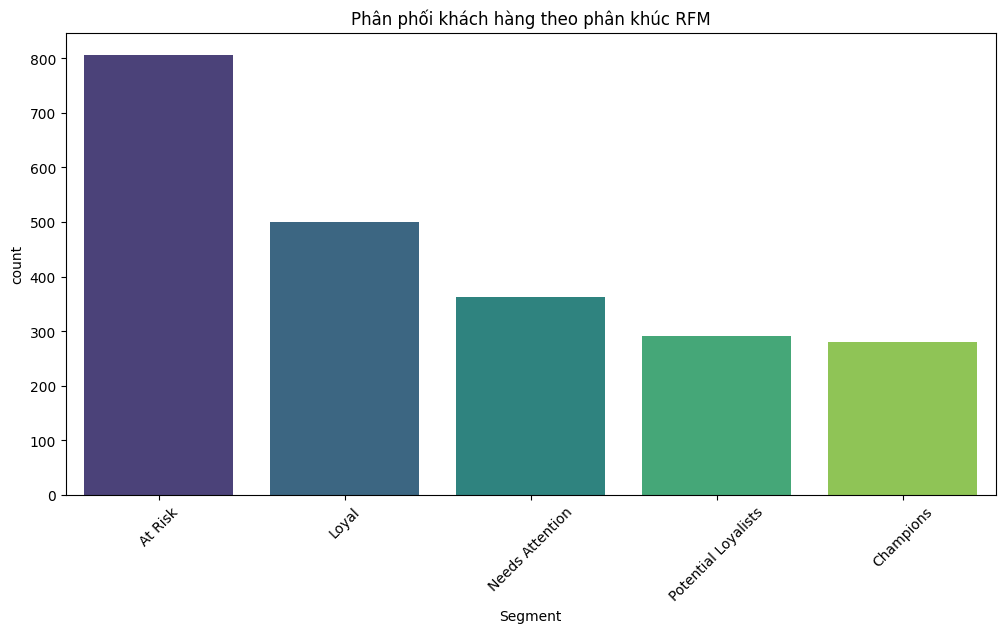

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# chart 7
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Segment', order=segment_counts.index, palette='viridis')
plt.xticks(rotation=45)
plt.title('Phân phối khách hàng theo phân khúc RFM')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# So sánh phân phối cụm theo RFM rule-based và theo KMeans
pd.crosstab(df['Segment'], df['Cluster'])  # 'Segment' là rule-based, 'Cluster' là KMeans


Cluster,0,1,2,3
Segment,,,,
At Risk,206,0,234,366
Champions,0,281,0,0
Loyal,124,210,144,22
Needs Attention,228,0,0,134
Potential Loyalists,0,1,248,42


- Cụm 0: Phần lớn là khách hàng đang rời bỏ và khách hàng cần quan tâm, vẫn còn một phần là khách hàng trung thành => nhóm từng có giá trị cao nhưng đang có rời bỏ cửa hàng, cần tái chăm sóc nhóm này và chú ý hơn nhóm này => có thể cứu được
- Cụm 1: Phần lớn là khách hàng Champion và Loyal => có giá trị cao, tệp khách hàng chính của doanh nghiệp, ưu tiên số 1
- Cụm 2: Cụm hỗ hợp nhưng phần lớn là khách hàng rời bỏ và một phần quan trọng khách hàng tiềm năng, bao gồm cả người rời bỏ và người mới bước chân vào hành trình khách hàng. NHóm này cần cẩn thận vì có nếu chăm sóc tốt thì vẫn có thể phát triển nhưng khả năng bỏ mặt cũng rất cao, nếu đầu tư quá nhiều vào nhóm này dễ gây tổn thất không đáng.

<Axes: xlabel='Segment', ylabel='Cluster'>

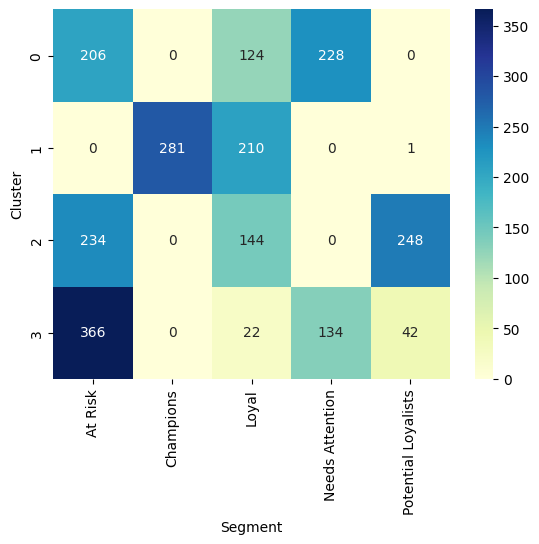

In [ ]:
# chart 8
import seaborn as sns
sns.heatmap(pd.crosstab(df['Cluster'], df['Segment']), annot=True, fmt='d', cmap='YlGnBu')
